In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [30]:
games = pd.read_csv("games.csv")
plays = pd.read_csv("plays.csv")
players = pd.read_csv("players.csv")
player_play = pd.read_csv("player_play.csv")

In [31]:
# the only information we really need from plays in their position and nflId

players = players[['nflId','position']]

# merge the position information into player_play 

player_play = pd.merge(player_play, players, how='inner', on='nflId')


In [32]:
# Now, let's only look at offensive players 

offensive_positions = ["WR", "RB", "TE", "T", "G", "QB", "C", "FB"]

offensive_player_play = player_play.loc[player_play['position'].isin(offensive_positions)]

offensive_cols_to_aggregate = ['rushingYards', 'passingYards', 'receivingYards', 'yardageGainedAfterTheCatch', 
 'fumbles', 'fumbleLost', 'fumbleOutOfBounds', 'inMotionAtBallSnap','shiftSinceLineset', 'pressureAllowedAsBlocker']


In [33]:
# data wrangling for plays
plays.columns

# NEW - dropped prepenaltyyards
plays.drop(columns=['playDescription', "prePenaltyYardsGained"], inplace= True)

correlations = plays.select_dtypes(include=['number']).corr()['yardsGained'].abs().sort_values(ascending=False)
print(correlations)

yardsGained                         1.000000
expectedPointsAdded                 0.751824
penaltyYards                        0.598588
passLength                          0.272620
timeToSack                          0.256250
expectedPoints                      0.099722
yardlineNumber                      0.085599
qbKneel                             0.074861
yardsToGo                           0.072102
dropbackDistance                    0.046731
timeToThrow                         0.032844
pff_runPassOption                   0.028168
timeInTackleBox                     0.025043
playId                              0.021388
quarter                             0.017360
down                                0.017346
targetY                             0.010769
gameId                              0.010282
absoluteYardlineNumber              0.003808
preSnapHomeScore                    0.002471
playClockAtSnap                     0.002058
targetX                             0.001729
preSnapHom

In [34]:
# sum all of the data of repeated position (i.e. WR's recieving yards are all summed)
aggregated_df = offensive_player_play.groupby(['playId', 'gameId'])[offensive_cols_to_aggregate].sum().reset_index()

# merge the DataFrames

merged_df = pd.merge(left=plays, right=aggregated_df, on=['playId', 'gameId'])

[gameID, playID, 

In [35]:

correlations = merged_df.select_dtypes(include=['number']).corr()['yardsGained'].abs().sort_values(ascending=False)
print(correlations)

yardsGained                         1.000000
passingYards                        0.795344
receivingYards                      0.794739
expectedPointsAdded                 0.751824
penaltyYards                        0.598588
yardageGainedAfterTheCatch          0.541315
rushingYards                        0.374595
passLength                          0.272620
timeToSack                          0.256250
pressureAllowedAsBlocker            0.130096
fumbles                             0.100161
expectedPoints                      0.099722
fumbleLost                          0.086197
yardlineNumber                      0.085599
qbKneel                             0.074861
yardsToGo                           0.072102
dropbackDistance                    0.046731
timeToThrow                         0.032844
pff_runPassOption                   0.028168
timeInTackleBox                     0.025043
playId                              0.021388
quarter                             0.017360
down      

to alter: gameclock, offense formation, receiver alignment, unblocked pressure, qbsneak, rush location type, pff-runconceptprimary, pff_runconceptsecondary, pff_passCoverage, pff-manZone, inMotionAtBallSnap (change to probably true false) and shiftsincelineset (probably also have to change to true false)

maybe keep maybe drop: pass result (idk maybe could help if supervised learning), pass location type, passtippedatlign

to drop: play description, yardlineside,  playNullifiedByPenalty already only has false so we can just drop

Also have to keep gameID and playID out of the regression model, 

Perhaps can drop time to sack,and potentially time to throw and timeinTackle box as these aren't always going to be there. 

In [36]:
merged_df.select_dtypes(include='number').columns

Index(['gameId', 'playId', 'quarter', 'down', 'yardsToGo', 'yardlineNumber',
       'preSnapHomeScore', 'preSnapVisitorScore', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'playClockAtSnap', 'passLength', 'targetX', 'targetY',
       'dropbackDistance', 'timeToThrow', 'timeInTackleBox', 'timeToSack',
       'qbKneel', 'penaltyYards', 'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded',
       'pff_runPassOption', 'rushingYards', 'passingYards', 'receivingYards',
       'yardageGainedAfterTheCatch', 'fumbles', 'fumbleLost',
       'fumbleOutOfBounds', 'pressureAllowedAsBlocker'],
      dtype='object')

### Preprocessing

In [37]:
# Assuming the format is "MM:SS"
merged_df["gameClock"] = merged_df["gameClock"].apply(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1]))

In [38]:
merged_df["gameClock"]

0        114
1        133
2        120
3        568
4        136
        ... 
16119    769
16120    752
16121    599
16122     45
16123    900
Name: gameClock, Length: 16124, dtype: int64

In [39]:
print(merged_df['receiverAlignment'].value_counts())


receiverAlignment
2x2    6483
3x1    6044
2x1    1824
3x2    1232
1x1     160
4x1     129
2x0      45
3x0       9
1x0       8
4x2       1
3x3       1
Name: count, dtype: int64


In [40]:
from scipy.stats import f_oneway

# Set minimum group size
min_group_size = 2

# List to store results
anova_results = []

# Iterate over all categorical columns
for col in merged_df.select_dtypes(include=['object', 'category']).columns:
    # Filter out small groups
    valid_categories = merged_df[col].value_counts()[lambda x: x >= min_group_size].index
    filtered_df = merged_df[merged_df[col].isin(valid_categories)]
    
    # Skip if less than 2 valid groups
    if len(valid_categories) < 2:
        print(f"Skipping {col} (not enough valid groups)")
        continue
    
    # Group data for ANOVA
    grouped_data = [filtered_df[filtered_df[col] == category]['yardsGained'] for category in valid_categories]
    
    # Perform ANOVA
    anova_result = f_oneway(*grouped_data)
    
    # Store results
    anova_results.append({
        'categorical_variable': col,
        'F-statistic': anova_result.statistic,
        'p-value': anova_result.pvalue
    })

# Create a DataFrame with the results
import pandas as pd
anova_results_df = pd.DataFrame(anova_results)

# Print or save the results
print(anova_results_df)


Skipping playNullifiedByPenalty (not enough valid groups)
       categorical_variable  F-statistic       p-value
0            possessionTeam     1.466873  4.543601e-02
1             defensiveTeam     1.183518  2.221069e-01
2              yardlineSide     1.560407  2.438962e-02
3          offenseFormation     5.039783  3.579455e-05
4         receiverAlignment     2.176530  2.614838e-02
5                passResult  1456.846722  0.000000e+00
6              dropbackType    14.103843  1.311720e-20
7          passLocationType    33.391289  3.549136e-15
8          passTippedAtLine    85.280436  3.156474e-20
9         unblockedPressure   126.934447  2.910403e-29
10                  qbSpike     9.909627  1.649343e-03
11                  qbSneak    16.435202  5.090455e-05
12         rushLocationType    33.996848  3.918645e-28
13    pff_runConceptPrimary     5.157754  3.964690e-08
14  pff_runConceptSecondary     1.777881  3.737253e-03
15         pff_passCoverage    10.442317  1.359733e-28
16     

Only non significant ones through ANOVA are defensiveteam and inMotionAtBallSnap

In [41]:
import numpy as np

# List to store correlation results
correlation_results = []

# Get all numerical columns
numerical_columns = merged_df.select_dtypes(include=[np.number]).columns

# Iterate through all pairs of numerical columns to compute correlation coefficients
for col in numerical_columns:
    if col != 'yardsGained':  # Assuming 'yardsGained' is the target variable
        correlation_coefficient = merged_df['yardsGained'].corr(merged_df[col])
        correlation_results.append({
            'numerical_variable': col,
            'correlation_coefficient': correlation_coefficient
        })

# Create a DataFrame with the results
correlation_results_df = pd.DataFrame(correlation_results)

# Display correlation results to the user

sorted_correlation_results_df = correlation_results_df.sort_values(by='correlation_coefficient', ascending=False)
sorted_correlation_results_df.loc[sorted_correlation_results_df["correlation_coefficient"] > .05]

,numerical_variable,correlation_coefficient
28,passingYards,0.795344
29,receivingYards,0.794739
25,expectedPointsAdded,0.751824
22,penaltyYards,0.598588
30,yardageGainedAfterTheCatch,0.541315
27,rushingYards,0.374595
14,passLength,0.272620
20,timeToSack,0.256250
5,yardlineNumber,0.085599
4,yardsToGo,0.072102


Most important ones to include are shown above. most of them are based after the ball is snapped.

### Encoding categorical variables

In [42]:
anova_results_df["categorical_variable"]

0              possessionTeam
1               defensiveTeam
2                yardlineSide
3            offenseFormation
4           receiverAlignment
5                  passResult
6                dropbackType
7            passLocationType
8            passTippedAtLine
9           unblockedPressure
10                    qbSpike
11                    qbSneak
12           rushLocationType
13      pff_runConceptPrimary
14    pff_runConceptSecondary
15           pff_passCoverage
16                pff_manZone
17         inMotionAtBallSnap
18          shiftSinceLineset
Name: categorical_variable, dtype: object

In [43]:
"""merged_df_encoded = merged_df.copy()

for col in anova_results_df["categorical_variable"]:
    # Calculate mean of yardsGained for each category
    target_mean = merged_df.groupby(col)["yardsGained"].mean()
    # Map the target mean back to the column
    merged_df_encoded[col] = merged_df[col].map(target_mean)
"""

'merged_df_encoded = merged_df.copy()\n\nfor col in anova_results_df["categorical_variable"]:\n    # Calculate mean of yardsGained for each category\n    target_mean = merged_df.groupby(col)["yardsGained"].mean()\n    # Map the target mean back to the column\n    merged_df_encoded[col] = merged_df[col].map(target_mean)\n'

### Model Training

In [44]:

# Assume `merged_df` is already loaded
# Example: merged_df has both numerical and categorical columns
# Ensure 'yardsGained' is the target variable

# Step 1: Split Data
X = merged_df.drop(['yardsGained'], axis=1)
y = merged_df['yardsGained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [45]:
# Step 2: Identify Categorical Columns
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

In [46]:
# Step 3: Perform Manual Target Encoding
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in categorical_columns:
    # Calculate mean of `yardsGained` for each category in the training set
    target_means = y_train.groupby(X_train[col]).mean()
    
    # Map the target means to the training and test set
    X_train_encoded[col] = X_train[col].map(target_means)
    X_test_encoded[col] = X_test[col].map(target_means)
    
    # Fill missing values in the test set with the global mean (for unseen categories)
    X_test_encoded[col] = X_test_encoded[col].fillna(y_train.mean())

# Step 4: Train the Model
xgb_model = XGBRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=8,
    random_state=42,
    objective='reg:squarederror'
)

xgb_model.fit(X_train_encoded, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test_encoded)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")

# Calculate training RMSE
y_train_pred = xgb_model.predict(X_train_encoded)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

# Calculate test RMSE
y_test_pred = xgb_model.predict(X_test_encoded)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print(f"Training RMSE: {rmse_train}")

XGBoost RMSE: 1.2389646572354054
Training RMSE: 0.4397831941840128


In [47]:
y_pred = xgb_model.predict(X_test_encoded)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")  

print(f"Mean Squared Error: {mse}")

Root Mean Squared Error: 1.2389646572354054
Mean Squared Error: 1.5350334218784458


### Graphing

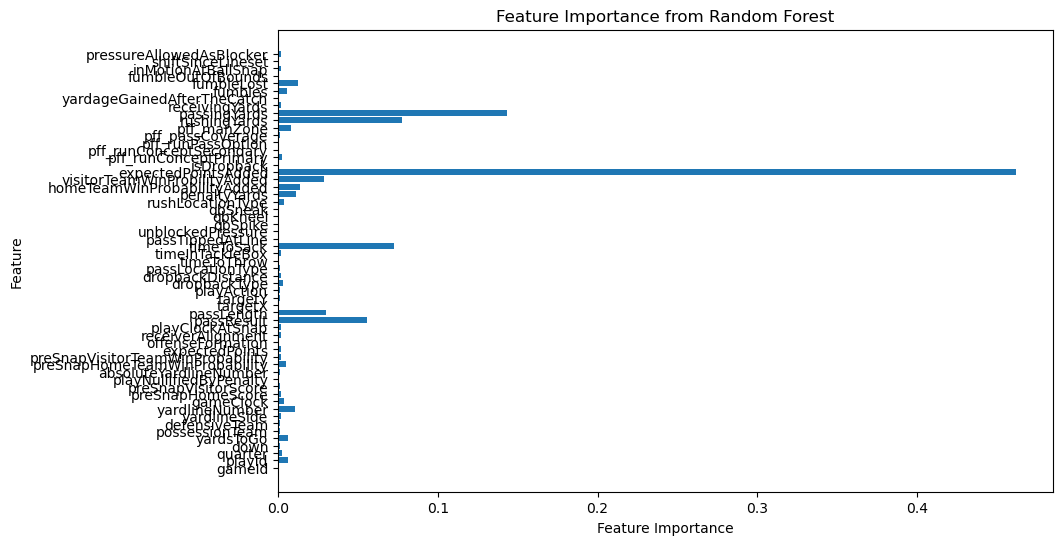

In [48]:
# Get feature importances
importances = xgb_model.feature_importances_
feature_names = X_train_encoded.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.show()

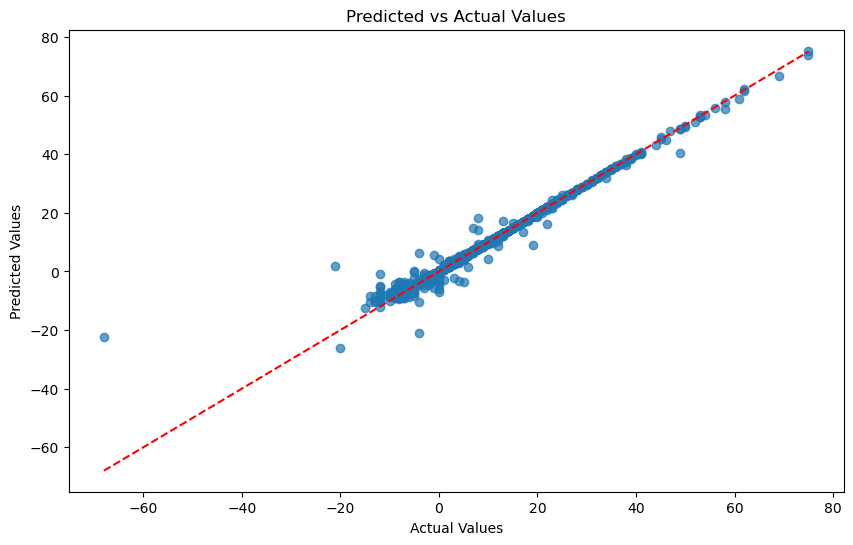

In [49]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()


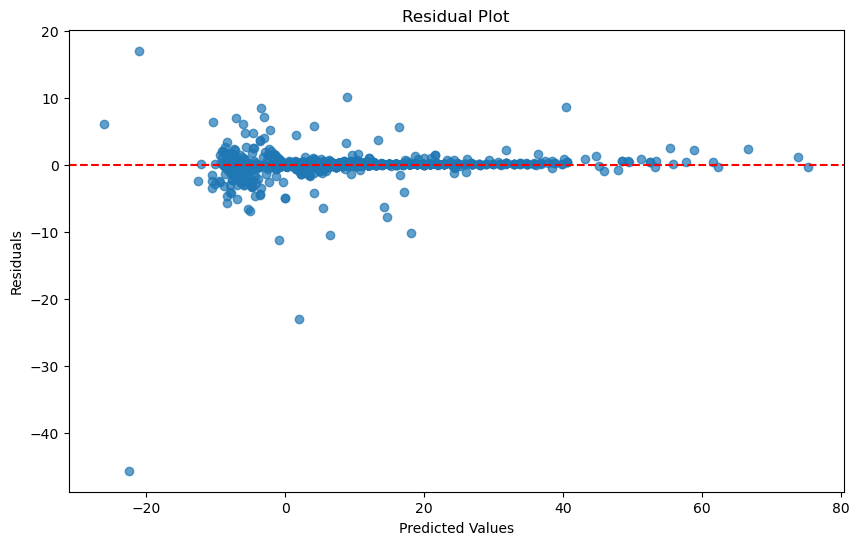

In [50]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


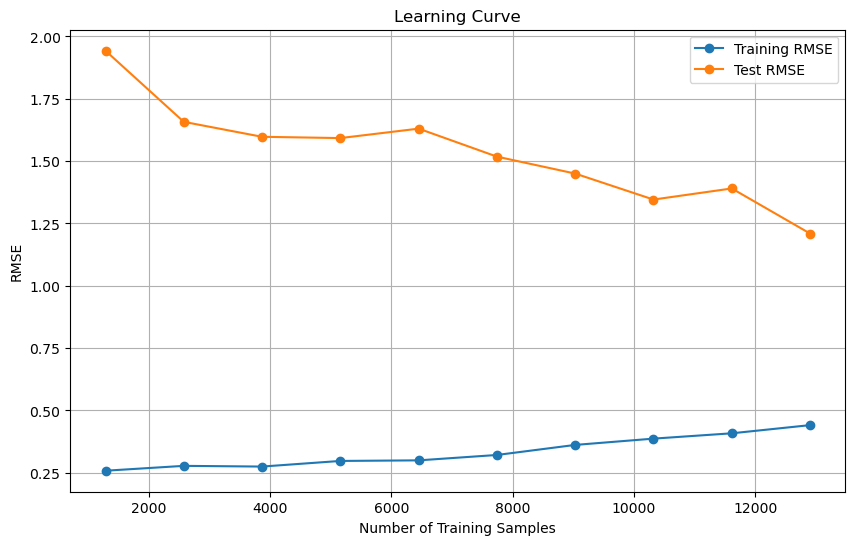

In [51]:
train_sizes = np.linspace(0.1, 1.0, 10)  # 10 steps from 10% to 100% of the training data
train_rmse = []
test_rmse = []



for train_size in train_sizes:
    # Get subset of the training data
    X_train_subset = X_train_encoded.sample(frac=train_size, random_state=42)
    y_train_subset = y_train[X_train_subset.index]



    xgb_model = XGBRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=8,
    random_state=42,
    objective='reg:squarederror'
    )
    xgb_model.fit(X_train_subset, y_train_subset)


    y_train_pred_subset = xgb_model.predict(X_train_subset)
    mse_train = mean_squared_error(y_train_subset, y_train_pred_subset)
    train_rmse.append(np.sqrt(mse_train))


    y_test_pred = xgb_model.predict(X_test_encoded)
    mse_test = mean_squared_error(y_test, y_test_pred)
    test_rmse.append(np.sqrt(mse_test))


plt.figure(figsize=(10, 6))
plt.plot(train_sizes * len(X_train_encoded), train_rmse, label="Training RMSE", marker='o')
plt.plot(train_sizes * len(X_train_encoded), test_rmse, label="Test RMSE", marker='o')
plt.xlabel("Number of Training Samples")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

- Best offense predicted
- Does play action/motion help the offense
- receiver sets help to predict things?
- whichh teams have the most beyond predicted by a significant margin 
- which teams used which types of plays the best